In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2, DenseNet201
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil
import warnings
warnings.filterwarnings("ignore")

2025-06-30 20:16:43.427429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751314603.608904      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751314603.660973      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Constants
RESIZE_DIM = (224, 224)
OUTPUT_DIR = '/kaggle/input/skin-cancer-disease-ham10000/Ham10000'
PROCESSED_DIR = '/kaggle/working/processed'

def has_black_borders(img, threshold=10):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray > threshold
    return not np.all(mask)

def zoom_until_no_borders(img, zoom_step=10, min_size=50):
    while has_black_borders(img):
        h, w, _ = img.shape
        if h <= min_size or w <= min_size:
            break
        img = img[zoom_step:h - zoom_step, zoom_step:w - zoom_step]
    return img

def apply_threshold(gray_image, lower_gray=20, upper_gray=100):
    return cv2.inRange(gray_image, lower_gray, upper_gray)

def find_and_draw_contours(image, mask, min_contour_area=500):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = image.copy()
    for contour in contours:
        if cv2.contourArea(contour) >= min_contour_area:
            cv2.drawContours(image_with_contours, [contour], -1, (0, 255, 0), 2)
    return image_with_contours

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if has_black_borders(image):
        image = zoom_until_no_borders(image)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    equalized = cv2.equalizeHist(blurred)
    resized_color = cv2.resize(image, RESIZE_DIM)
    resized_gray = cv2.resize(equalized, RESIZE_DIM)
    
    mask = apply_threshold(resized_gray)
    gray_highlighted = cv2.bitwise_and(resized_gray, resized_gray, mask=mask)
    color_with_contours = find_and_draw_contours(resized_color, mask)
    gray_with_contours = find_and_draw_contours(resized_gray, mask)
    
    return {
        "original": resized_color,
        "gray": resized_gray,
        "highlighted": gray_highlighted,
        "color_contour": color_with_contours,
        "gray_contour": gray_with_contours
    }

def create_processed_dataset():
    for class_name in os.listdir(OUTPUT_DIR):
        class_path = os.path.join(OUTPUT_DIR, class_name)
        if not os.path.isdir(class_path):
            continue
        
        images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        
        for img_path in tqdm(images, desc=f"Processing {class_name}"):
            processed_images = preprocess_image(img_path)
            for key, img in processed_images.items():
                output_class_dir = os.path.join(PROCESSED_DIR, key, class_name)
                os.makedirs(output_class_dir, exist_ok=True)
                output_img_path = os.path.join(output_class_dir, os.path.basename(img_path))
                cv2.imwrite(output_img_path, img)
    print("Processed dataset created successfully!")

def count_images_in_classes(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
            print(f"Class '{class_name}': {num_images} images")
    return class_counts


In [8]:
create_processed_dataset()

count_images_in_classes(os.path.join(PROCESSED_DIR, "original"))
count_images_in_classes(os.path.join(PROCESSED_DIR, "gray"))
count_images_in_classes(os.path.join(PROCESSED_DIR, "highlighted"))
count_images_in_classes(os.path.join(PROCESSED_DIR, "color_contour"))
count_images_in_classes(os.path.join(PROCESSED_DIR, "gray_contour"))


Processing Dermatofibroma: 100%|██████████| 115/115 [00:01<00:00, 80.35it/s]


Processed dataset created successfully!
Class 'Melanocytic nevi': 6705 images
Class 'Vascular lesions': 142 images
Class 'Melanoma': 1113 images
Class 'Basal cell carcinoma': 514 images
Class 'Actinic keratoses': 327 images
Class 'Dermatofibroma': 115 images
Class 'Benign keratosis-like lesions': 1099 images
Class 'Melanocytic nevi': 6705 images
Class 'Vascular lesions': 142 images
Class 'Melanoma': 1113 images
Class 'Basal cell carcinoma': 514 images
Class 'Actinic keratoses': 327 images
Class 'Dermatofibroma': 115 images
Class 'Benign keratosis-like lesions': 1099 images
Class 'Melanocytic nevi': 6705 images
Class 'Vascular lesions': 142 images
Class 'Melanoma': 1113 images
Class 'Basal cell carcinoma': 514 images
Class 'Actinic keratoses': 327 images
Class 'Dermatofibroma': 115 images
Class 'Benign keratosis-like lesions': 1099 images
Class 'Melanocytic nevi': 6705 images
Class 'Vascular lesions': 142 images
Class 'Melanoma': 1113 images
Class 'Basal cell carcinoma': 514 images
Clas

{'Melanocytic nevi': 6705,
 'Vascular lesions': 142,
 'Melanoma': 1113,
 'Basal cell carcinoma': 514,
 'Actinic keratoses': 327,
 'Dermatofibroma': 115,
 'Benign keratosis-like lesions': 1099}

# Original

In [2]:
original_dir_Original = '/kaggle/input/skin-cancer-disease-ham10000/Ham10000'
output_dir_Original = '/kaggle/working/skin_split_Original'

for split_Original in ['train_Original', 'val_Original', 'test_Original']:
    os.makedirs(f"{output_dir_Original}/{split_Original}", exist_ok=True)

print("✅ Started splitting...\n")

for class_name_Original in os.listdir(original_dir_Original):
    class_path_Original = os.path.join(original_dir_Original, class_name_Original)
    if os.path.isdir(class_path_Original):
        images_Original = os.listdir(class_path_Original)
        random.shuffle(images_Original)
        n_Original = len(images_Original)
        train_n_Original = int(0.7 * n_Original)
        val_n_Original = int(0.15 * n_Original)

        train_files_Original = images_Original[:train_n_Original]
        val_files_Original = images_Original[train_n_Original:train_n_Original + val_n_Original]
        test_files_Original = images_Original[train_n_Original + val_n_Original:]

        for split_name_Original, split_files_Original in zip(['train_Original', 'val_Original', 'test_Original'], [train_files_Original, val_files_Original, test_files_Original]):
            split_class_dir_Original = os.path.join(output_dir_Original, split_name_Original, class_name_Original)
            os.makedirs(split_class_dir_Original, exist_ok=True)
            for file_Original in split_files_Original:
                shutil.copy(os.path.join(class_path_Original, file_Original), os.path.join(split_class_dir_Original, file_Original))
        
        print(f"✅ Class: {class_name_Original}")
        print(f"   Train: {len(train_files_Original)}")
        print(f"   Val:   {len(val_files_Original)}")
        print(f"   Test:  {len(test_files_Original)}")
        print("-" * 40)

print("\n✅✅ Splitting complete ✔️")

✅ Started splitting...

✅ Class: Benign keratosis-like lesions
   Train: 769
   Val:   164
   Test:  166
----------------------------------------
✅ Class: Actinic keratoses
   Train: 228
   Val:   49
   Test:  50
----------------------------------------
✅ Class: Melanoma
   Train: 779
   Val:   166
   Test:  168
----------------------------------------
✅ Class: Basal cell carcinoma
   Train: 359
   Val:   77
   Test:  78
----------------------------------------
✅ Class: Melanocytic nevi
   Train: 4693
   Val:   1005
   Test:  1007
----------------------------------------
✅ Class: Vascular lesions
   Train: 99
   Val:   21
   Test:  22
----------------------------------------
✅ Class: Dermatofibroma
   Train: 80
   Val:   17
   Test:  18
----------------------------------------

✅✅ Splitting complete ✔️


In [3]:
img_height_Original, img_width_Original = 224, 224
batch_size_Original = 32

train_datagen_Original = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen_Original = ImageDataGenerator(rescale=1./255)

train_data_Original = train_datagen_Original.flow_from_directory(
    f"{output_dir_Original}/train_Original",
    target_size=(img_height_Original, img_width_Original),
    batch_size=batch_size_Original,
    class_mode='categorical',
    shuffle=True
)

val_data_Original = val_test_datagen_Original.flow_from_directory(
    f"{output_dir_Original}/val_Original",
    target_size=(img_height_Original, img_width_Original),
    batch_size=batch_size_Original,
    class_mode='categorical',
    shuffle=False
)

test_data_Original = val_test_datagen_Original.flow_from_directory(
    f"{output_dir_Original}/test_Original",
    target_size=(img_height_Original, img_width_Original),
    batch_size=batch_size_Original,
    class_mode='categorical',
    shuffle=False
)

num_classes_Original = train_data_Original.num_classes


Found 7007 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
Found 1509 images belonging to 7 classes.


In [ ]:
def build_model(base_model_class, input_shape=(224, 224, 3), num_classes=7):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
model_Original1 = build_model(DenseNet201, input_shape=(224, 224, 3), num_classes=num_classes_Original)
model_Original1.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_Original1 = ModelCheckpoint('best_densenet201_Original_2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model_Original1.fit(
    train_data_Original,
    validation_data=val_data_Original,
    epochs=2,
    callbacks=[checkpoint_Original1]
)

Epoch 1/2


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
best_model_Original1 = load_model('best_densenet201_Original_2.h5')

# Evaluate on the validation set
val_loss, val_acc = best_model_Original1.evaluate(val_data_Original, verbose=1)
print(f"✅ Final Validation Accuracy (Saved Checkpoint): {val_acc:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (Original)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"📌 Final Train Accuracy (Last Epoch): {final_train_acc:.4f}")
print(f"📌 Final Validation Accuracy (Last Epoch): {final_val_acc:.4f}")

In [9]:
model_Original = build_model(DenseNet201, input_shape=(224, 224, 3), num_classes=num_classes_Original)
model_Original.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_Original = ModelCheckpoint('best_densenet201_Original.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history_original = model_Original.fit(
    train_data_Original,
    validation_data=val_data_Original,
    epochs=50,
    callbacks=[checkpoint_Original]
)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5094 - loss: 1.4197
Epoch 1: val_accuracy improved from -inf to 0.67645, saving model to best_densenet201_Original.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.5099 - loss: 1.4183 - val_accuracy: 0.6765 - val_loss: 0.9769
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7016 - loss: 0.8353
Epoch 2: val_accuracy improved from 0.67645 to 0.74850, saving model to best_densenet201_Original.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 128s 582ms/step - accuracy: 0.7017 - loss: 0.8351 - val_accuracy: 0.7485 - val_loss: 0.7157
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7283 - loss: 0.7380
Epoch 3: val_accuracy improved from 0.74850 to 0.77585, saving model to best_densenet201_Original.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 128s 583ms/step - accuracy: 0.7284 - loss: 0.7379 - val_accuracy: 0.7759 - val_loss: 0.6613
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.7595 - loss

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step
✅ Test Accuracy (Original): 0.8463

✅ Classification Report (Original):
                               precision    recall  f1-score   support

            Actinic keratoses       0.93      0.26      0.41        50
         Basal cell carcinoma       0.89      0.73      0.80        78
Benign keratosis-like lesions       0.60      0.87      0.71       166
               Dermatofibroma       0.71      0.67      0.69        18
             Melanocytic nevi       0.97      0.89      0.93      1007
                     Melanoma       0.58      0.82      0.68       168
             Vascular lesions       0.90      0.86      0.88        22

                     accuracy                           0.85      1509
                    macro avg       0.80      0.73      0.73      1509
                 weighted avg       0.88      0.85      0.85      1509



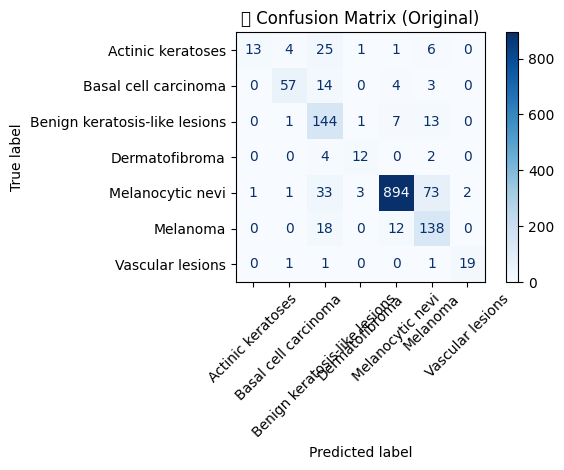

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict class probabilities
y_pred_probs_Original = model_Original.predict(test_data_Original, verbose=1)

# Step 2: Convert probabilities to class indices
y_pred_Original = np.argmax(y_pred_probs_Original, axis=1)

# Step 3: Get true class indices
y_true_Original = test_data_Original.classes

# Step 4: Calculate test accuracy
test_accuracy_Original = accuracy_score(y_true_Original, y_pred_Original)
print(f"✅ Test Accuracy (Original): {test_accuracy_Original:.4f}")

# Step 5: Print classification report
class_labels_Original = list(test_data_Original.class_indices.keys())
print("\n✅ Classification Report (Original):")
print(classification_report(y_true_Original, y_pred_Original, target_names=class_labels_Original))

# Step 6: Confusion Matrix
cm_Original = confusion_matrix(y_true_Original, y_pred_Original)
disp_Original = ConfusionMatrixDisplay(confusion_matrix=cm_Original, display_labels=class_labels_Original)
disp_Original.plot(cmap='Blues', xticks_rotation=45)
plt.title("✅ Confusion Matrix (Original)")
plt.tight_layout()
plt.show()

In [ ]:
# Load the best model saved during training
best_model_Original = load_model('best_densenet201_Original.h5')

# Evaluate on the validation set
val_loss_original, val_acc_original = best_model_Original.evaluate(val_data_Original, verbose=1)
print(f"✅ Final Validation Accuracy (Saved Checkpoint): {val_acc_original:.4f}")

In [ ]:
# Plot training and validation accuracy
plt.plot(history_original.history['accuracy'], label='Train Accuracy')
plt.plot(history_original.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (Original)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
final_train_acc_original = history_original.history['accuracy'][-1]
final_val_acc_original = history_original.history['val_accuracy'][-1]

print(f"📌 Final Train Accuracy (Last Epoch): {final_train_acc_original:.4f}")
print(f"📌 Final Validation Accuracy (Last Epoch): {final_val_acc_original:.4f}")

# Color Contour

In [16]:
original_dir_color_contour = '/kaggle/working/processed/color_contour'
output_dir_color_contour = '/kaggle/working/color_contour_split'

for split_color_contour in ['train_color_contour', 'val_color_contour', 'test_color_contour']:
    os.makedirs(f"{output_dir_color_contour}/{split_color_contour}", exist_ok=True)

print("✅ Started splitting...\n")

for class_name_color_contour in os.listdir(original_dir_color_contour):
    class_path_color_contour = os.path.join(original_dir_color_contour, class_name_color_contour)
    if os.path.isdir(class_path_color_contour):
        images_color_contour = os.listdir(class_path_color_contour)
        random.shuffle(images_color_contour)
        n_color_contour = len(images_color_contour)
        train_n_color_contour = int(0.7 * n_color_contour)
        val_n_color_contour = int(0.15 * n_color_contour)

        train_files_color_contour = images_color_contour[:train_n_color_contour]
        val_files_color_contour = images_color_contour[train_n_color_contour:train_n_color_contour + val_n_color_contour]
        test_files_color_contour = images_color_contour[train_n_color_contour + val_n_color_contour:]

        for split_name_color_contour, split_files_color_contour in zip(['train_color_contour', 'val_color_contour', 'test_color_contour'], [train_files_color_contour, val_files_color_contour, test_files_color_contour]):
            split_class_dir_color_contour = os.path.join(output_dir_color_contour, split_name_color_contour, class_name_color_contour)
            os.makedirs(split_class_dir_color_contour, exist_ok=True)
            for file_color_contour in split_files_color_contour:
                shutil.copy(os.path.join(class_path_color_contour, file_color_contour), os.path.join(split_class_dir_color_contour, file_color_contour))
        
        print(f"✅ Class: {class_name_color_contour}")
        print(f"   Train: {len(train_files_color_contour)}")
        print(f"   Val:   {len(val_files_color_contour)}")
        print(f"   Test:  {len(test_files_color_contour)}")
        print("-" * 40)

print("\n✅✅ Splitting complete ✔️")


✅ Started splitting...

✅ Class: Melanocytic nevi
   Train: 4693
   Val:   1005
   Test:  1007
----------------------------------------
✅ Class: Vascular lesions
   Train: 99
   Val:   21
   Test:  22
----------------------------------------
✅ Class: Melanoma
   Train: 779
   Val:   166
   Test:  168
----------------------------------------
✅ Class: Basal cell carcinoma
   Train: 359
   Val:   77
   Test:  78
----------------------------------------
✅ Class: Actinic keratoses
   Train: 228
   Val:   49
   Test:  50
----------------------------------------
✅ Class: Dermatofibroma
   Train: 80
   Val:   17
   Test:  18
----------------------------------------
✅ Class: Benign keratosis-like lesions
   Train: 769
   Val:   164
   Test:  166
----------------------------------------

✅✅ Splitting complete ✔️


In [17]:
img_height_color_contour, img_width_color_contour = 224, 224
batch_size_color_contour = 32

train_datagen_color_contour = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen_color_contour = ImageDataGenerator(rescale=1./255)

train_data_color_contour = train_datagen_color_contour.flow_from_directory(
    f"{output_dir_color_contour}/train_color_contour",
    target_size=(img_height_color_contour, img_width_color_contour),
    batch_size=batch_size_color_contour,
    class_mode='categorical',
    shuffle=True
)

val_data_color_contour = val_test_datagen_color_contour.flow_from_directory(
    f"{output_dir_color_contour}/val_color_contour",
    target_size=(img_height_color_contour, img_width_color_contour),
    batch_size=batch_size_color_contour,
    class_mode='categorical',
    shuffle=False
)

test_data_color_contour = val_test_datagen_color_contour.flow_from_directory(
    f"{output_dir_color_contour}/test_color_contour",
    target_size=(img_height_color_contour, img_width_color_contour),
    batch_size=batch_size_color_contour,
    class_mode='categorical',
    shuffle=False
)

num_classes_color_contour = train_data_color_contour.num_classes


Found 9092 images belonging to 7 classes.
Found 2772 images belonging to 7 classes.
Found 2776 images belonging to 7 classes.


In [18]:
def build_model(base_model_class, input_shape=(224, 224, 3), num_classes=7):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [19]:
model_color_contour = build_model(DenseNet201, input_shape=(224, 224, 3), num_classes=num_classes_color_contour)
model_color_contour.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_color_contour = ModelCheckpoint('best_densenet201_color_contour.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model_color_contour.fit(
    train_data_color_contour,
    validation_data=val_data_color_contour,
    epochs=50,
    callbacks=[checkpoint_color_contour]
)


Epoch 1/50
166/285 ━━━━━━━━━━━━━━━━━━━━ 46s 392ms/step - accuracy: 0.3808 - loss: 1.7846

2025-06-30 15:32:50.440663: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_770130__.89618] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-06-30 15:36:23.276997: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5m32.836468365s

********************************
[Compiling module a_inference_one_step_on_data_770130__.89618] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4633 - loss: 1.5642
Epoch 1: val_accuracy improved from -inf to 0.68975, saving model to best_densenet201_color_contour.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 988s 2s/step - accuracy: 0.4638 - loss: 1.5628 - val_accuracy: 0.6898 - val_loss: 0.8630
Epoch 2/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6978 - loss: 0.8907
Epoch 2: val_accuracy improved from 0.68975 to 0.73701, saving model to best_densenet201_color_contour.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 120s 421ms/step - accuracy: 0.6978 - loss: 0.8906 - val_accuracy: 0.7370 - val_loss: 0.7239
Epoch 3/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7239 - loss: 0.7698
Epoch 3: val_accuracy improved from 0.73701 to 0.76263, saving model to best_densenet201_color_contour.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 120s 422ms/step - accuracy: 0.7239 - loss: 0.7697 - val_accuracy: 0.7626 - val_loss: 0.6533
Epoch 4/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7505 - 

87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 373ms/step
✅ Test Accuracy (Color Contour): 0.9456

✅ Classification Report (Color Contour):
                               precision    recall  f1-score   support

            Actinic keratoses       0.95      0.86      0.90        93
         Basal cell carcinoma       0.90      0.91      0.90       141
Benign keratosis-like lesions       0.85      0.94      0.89       307
               Dermatofibroma       1.00      0.91      0.95        32
             Melanocytic nevi       0.98      0.96      0.97      1858
                     Melanoma       0.84      0.91      0.88       305
             Vascular lesions       1.00      0.93      0.96        40

                     accuracy                           0.95      2776
                    macro avg       0.93      0.92      0.92      2776
                 weighted avg       0.95      0.95      0.95      2776



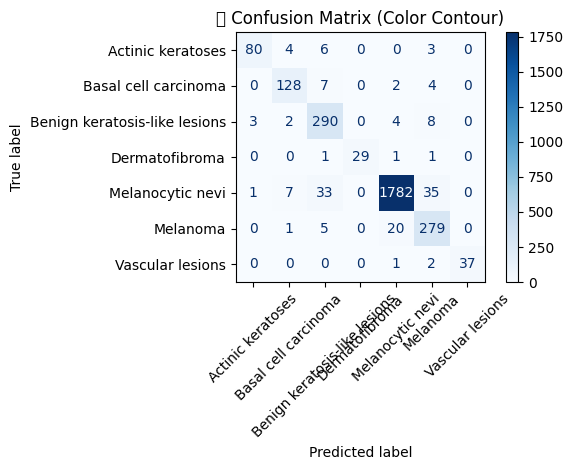

In [20]:
# Step 1: Predict class probabilities
y_pred_probs_color_contour = model_color_contour.predict(test_data_color_contour, verbose=1)

# Step 2: Convert probabilities to class indices
y_pred_color_contour = np.argmax(y_pred_probs_color_contour, axis=1)

# Step 3: Get true class indices
y_true_color_contour = test_data_color_contour.classes

# Step 4: Calculate test accuracy
test_accuracy_color_contour = accuracy_score(y_true_color_contour, y_pred_color_contour)
print(f"✅ Test Accuracy (Color Contour): {test_accuracy_color_contour:.4f}")

# Step 5: Print classification report
class_labels_color_contour = list(test_data_color_contour.class_indices.keys())
print("\n✅ Classification Report (Color Contour):")
print(classification_report(y_true_color_contour, y_pred_color_contour, target_names=class_labels_color_contour))

# Step 6: Confusion Matrix
cm_color_contour = confusion_matrix(y_true_color_contour, y_pred_color_contour)
disp_color_contour = ConfusionMatrixDisplay(confusion_matrix=cm_color_contour, display_labels=class_labels_color_contour)
disp_color_contour.plot(cmap='Blues', xticks_rotation=45)
plt.title("✅ Confusion Matrix (Color Contour)")
plt.tight_layout()
plt.show()


# Gray

In [21]:
original_dir_gray = '/kaggle/working/processed/gray'
output_dir_gray = '/kaggle/working/skin_split_gray'

for split_gray in ['train_gray', 'val_gray', 'test_gray']:
    os.makedirs(f"{output_dir_Original}/{split_gray}", exist_ok=True)

print("✅ Started splitting...\n")

for class_name_gray in os.listdir(original_dir_Original):
    class_path_gray = os.path.join(original_dir_Original, class_name_gray)
    if os.path.isdir(class_path_gray):
        images_gray = os.listdir(class_path_gray)
        random.shuffle(images_gray)
        n_gray = len(images_gray)
        train_n_gray = int(0.7 * n_gray)
        val_n_gray = int(0.15 * n_gray)

        train_files_gray = images_gray[:train_n_gray]
        val_files_gray = images_gray[train_n_gray:train_n_gray + val_n_gray]
        test_files_gray = images_gray[train_n_gray + val_n_gray:]

        for split_name_gray, split_files_gray in zip(['train_gray', 'val_gray', 'test_gray'], [train_files_gray, val_files_gray, test_files_gray]):
            split_class_dir_gray = os.path.join(output_dir_Original, split_name_gray, class_name_gray)
            os.makedirs(split_class_dir_gray, exist_ok=True)
            for file_gray in split_files_gray:
                shutil.copy(os.path.join(class_path_gray, file_gray), os.path.join(split_class_dir_gray, file_gray))
        
        print(f"✅ Class: {class_name_gray}")
        print(f"   Train: {len(train_files_gray)}")
        print(f"   Val:   {len(val_files_gray)}")
        print(f"   Test:  {len(test_files_gray)}")
        print("-" * 40)

print("\n✅✅ Splitting complete ✔️")


✅ Started splitting...

✅ Class: Benign keratosis-like lesions
   Train: 769
   Val:   164
   Test:  166
----------------------------------------
✅ Class: Actinic keratoses
   Train: 228
   Val:   49
   Test:  50
----------------------------------------
✅ Class: Melanoma
   Train: 779
   Val:   166
   Test:  168
----------------------------------------
✅ Class: Basal cell carcinoma
   Train: 359
   Val:   77
   Test:  78
----------------------------------------
✅ Class: Melanocytic nevi
   Train: 4693
   Val:   1005
   Test:  1007
----------------------------------------
✅ Class: Vascular lesions
   Train: 99
   Val:   21
   Test:  22
----------------------------------------
✅ Class: Dermatofibroma
   Train: 80
   Val:   17
   Test:  18
----------------------------------------

✅✅ Splitting complete ✔️


In [22]:
img_height_gray, img_width_gray = 224, 224
batch_size_gray = 32

train_datagen_gray = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen_gray = ImageDataGenerator(rescale=1./255)

train_data_gray = train_datagen_gray.flow_from_directory(
    f"{output_dir_Original}/train_gray",
    target_size=(img_height_gray, img_width_gray),
    batch_size=batch_size_gray,
    class_mode='categorical',
    shuffle=True
)

val_data_gray = val_test_datagen_gray.flow_from_directory(
    f"{output_dir_Original}/val_gray",
    target_size=(img_height_gray, img_width_gray),
    batch_size=batch_size_gray,
    class_mode='categorical',
    shuffle=False
)

test_data_gray = val_test_datagen_gray.flow_from_directory(
    f"{output_dir_Original}/test_gray",
    target_size=(img_height_gray, img_width_gray),
    batch_size=batch_size_gray,
    class_mode='categorical',
    shuffle=False
)

num_classes_gray = train_data_gray.num_classes

Found 7007 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
Found 1509 images belonging to 7 classes.


In [23]:
def build_model(base_model_class, input_shape=(224, 224, 3), num_classes=7):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [24]:
model_gray = build_model(DenseNet201, input_shape=(224, 224, 3), num_classes=num_classes_gray)
model_gray.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_gray = ModelCheckpoint('best_densenet201_gray.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model_gray.fit(
    train_data_gray,
    validation_data=val_data_gray,
    epochs=50,
    callbacks=[checkpoint_gray]
)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4489 - loss: 1.5729
Epoch 1: val_accuracy improved from -inf to 0.67912, saving model to best_densenet201_gray.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - accuracy: 0.4496 - loss: 1.5711 - val_accuracy: 0.6791 - val_loss: 0.9444
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.7076 - loss: 0.8518
Epoch 2: val_accuracy improved from 0.67912 to 0.75450, saving model to best_densenet201_gray.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 132s 602ms/step - accuracy: 0.7076 - loss: 0.8517 - val_accuracy: 0.7545 - val_loss: 0.6932
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.7217 - loss: 0.7773
Epoch 3: val_accuracy did not improve from 0.75450
219/219 ━━━━━━━━━━━━━━━━━━━━ 128s 583ms/step - accuracy: 0.7217 - loss: 0.7772 - val_accuracy: 0.7445 - val_loss: 0.6854
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.7574 - loss: 0.6681
Epoch 4: val_accuracy improved from 0.75450 to 0.

48/48 ━━━━━━━━━━━━━━━━━━━━ 57s 666ms/step
✅ Test Accuracy (Gray): 0.8595

✅ Classification Report (Gray):
                               precision    recall  f1-score   support

            Actinic keratoses       1.00      0.18      0.31        50
         Basal cell carcinoma       0.92      0.69      0.79        78
Benign keratosis-like lesions       0.58      0.90      0.71       166
               Dermatofibroma       1.00      0.61      0.76        18
             Melanocytic nevi       0.96      0.92      0.94      1007
                     Melanoma       0.67      0.73      0.70       168
             Vascular lesions       0.96      1.00      0.98        22

                     accuracy                           0.86      1509
                    macro avg       0.87      0.72      0.74      1509
                 weighted avg       0.89      0.86      0.86      1509



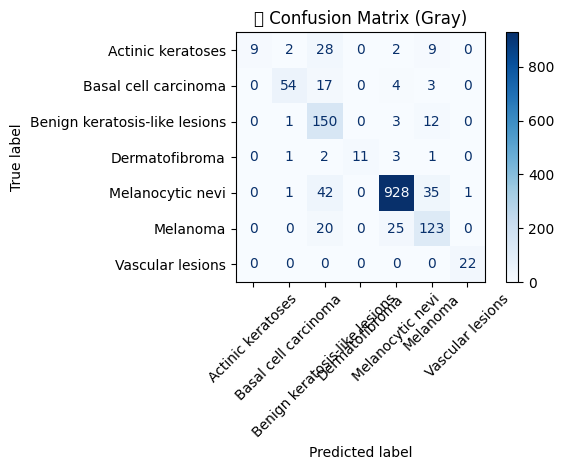

In [25]:
# Step 1: Predict class probabilities
y_pred_probs_gray = model_gray.predict(test_data_gray, verbose=1)

# Step 2: Convert probabilities to class indices
y_pred_gray = np.argmax(y_pred_probs_gray, axis=1)

# Step 3: Get true class indices
y_true_gray = test_data_gray.classes

# Step 4: Calculate test accuracy
test_accuracy_gray = accuracy_score(y_true_gray, y_pred_gray)
print(f"✅ Test Accuracy (Gray): {test_accuracy_gray:.4f}")

# Step 5: Print classification report
class_labels_gray = list(test_data_gray.class_indices.keys())
print("\n✅ Classification Report (Gray):")
print(classification_report(y_true_gray, y_pred_gray, target_names=class_labels_gray))

# Step 6: Confusion Matrix
cm_gray = confusion_matrix(y_true_gray, y_pred_gray)
disp_gray = ConfusionMatrixDisplay(confusion_matrix=cm_gray, display_labels=class_labels_gray)
disp_gray.plot(cmap='Blues', xticks_rotation=45)
plt.title("✅ Confusion Matrix (Gray)")
plt.tight_layout()
plt.show()

# Gray Contour

In [31]:
original_dir_gray_contour = '/kaggle/working/processed/gray_contour'
output_dir_gray_contour = '/kaggle/working/skin_split_gray_contour'

for split_gray_contour in ['train_gray_contour', 'val_gray_contour', 'test_gray_contour']:
    os.makedirs(f"{output_dir_gray_contour}/{split_gray_contour}", exist_ok=True)

print("✅ Started splitting...\n")

for class_name_gray_contour in os.listdir(original_dir_gray_contour):
    class_path_gray_contour = os.path.join(original_dir_gray_contour, class_name_gray_contour)
    if os.path.isdir(class_path_gray_contour):
        images_gray_contour = os.listdir(class_path_gray_contour)
        random.shuffle(images_gray_contour)
        n_gray_contour = len(images_gray_contour)
        train_n_gray_contour = int(0.7 * n_gray_contour)
        val_n_gray_contour = int(0.15 * n_gray_contour)

        train_files_gray_contour = images_gray_contour[:train_n_gray_contour]
        val_files_gray_contour = images_gray_contour[train_n_gray_contour:train_n_gray_contour + val_n_gray_contour]
        test_files_gray_contour = images_gray_contour[train_n_gray_contour + val_n_gray_contour:]

        for split_name_gray_contour, split_files_gray_contour in zip(['train_gray_contour', 'val_gray_contour', 'test_gray_contour'], [train_files_gray_contour, val_files_gray_contour, test_files_gray_contour]):
            split_class_dir_gray_contour = os.path.join(output_dir_gray_contour, split_name_gray_contour, class_name_gray_contour)
            os.makedirs(split_class_dir_gray_contour, exist_ok=True)
            for file_gray_contour in split_files_gray_contour:
                shutil.copy(os.path.join(class_path_gray_contour, file_gray_contour), os.path.join(split_class_dir_gray_contour, file_gray_contour))
        
        print(f"✅ Class: {class_name_gray_contour}")
        print(f"   Train: {len(train_files_gray_contour)}")
        print(f"   Val:   {len(val_files_gray_contour)}")
        print(f"   Test:  {len(test_files_gray_contour)}")
        print("-" * 40)

print("\n✅✅ Splitting complete ✔️")

✅ Started splitting...

✅ Class: Melanocytic nevi
   Train: 4693
   Val:   1005
   Test:  1007
----------------------------------------
✅ Class: Vascular lesions
   Train: 99
   Val:   21
   Test:  22
----------------------------------------
✅ Class: Melanoma
   Train: 779
   Val:   166
   Test:  168
----------------------------------------
✅ Class: Basal cell carcinoma
   Train: 359
   Val:   77
   Test:  78
----------------------------------------
✅ Class: Actinic keratoses
   Train: 228
   Val:   49
   Test:  50
----------------------------------------
✅ Class: Dermatofibroma
   Train: 80
   Val:   17
   Test:  18
----------------------------------------
✅ Class: Benign keratosis-like lesions
   Train: 769
   Val:   164
   Test:  166
----------------------------------------

✅✅ Splitting complete ✔️


In [32]:
img_height_gray_contour, img_width_gray_contour = 224, 224
batch_size_gray_contour = 32

train_datagen_gray_contour = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen_gray_contour = ImageDataGenerator(rescale=1./255)

train_data_gray_contour = train_datagen_gray_contour.flow_from_directory(
    f"{output_dir_gray_contour}/train_gray_contour",
    target_size=(img_height_gray_contour, img_width_gray_contour),
    batch_size=batch_size_gray_contour,
    class_mode='categorical',
    shuffle=True
)

val_data_gray_contour = val_test_datagen_gray_contour.flow_from_directory(
    f"{output_dir_gray_contour}/val_gray_contour",
    target_size=(img_height_gray_contour, img_width_gray_contour),
    batch_size=batch_size_gray_contour,
    class_mode='categorical',
    shuffle=False
)

test_data_gray_contour = val_test_datagen_gray_contour.flow_from_directory(
    f"{output_dir_gray_contour}/test_gray_contour",
    target_size=(img_height_gray_contour, img_width_gray_contour),
    batch_size=batch_size_gray_contour,
    class_mode='categorical',
    shuffle=False
)

num_classes_gray_contour = train_data_gray_contour.num_classes

Found 9739 images belonging to 7 classes.
Found 3860 images belonging to 7 classes.
Found 3840 images belonging to 7 classes.


In [33]:
def build_model(base_model_class, input_shape=(224, 224, 3), num_classes=7):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [34]:
model_gray_contour = build_model(DenseNet201, input_shape=(224, 224, 3), num_classes=num_classes_gray_contour)
model_gray_contour.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_gray_contour = ModelCheckpoint('best_densenet201_gray_contour.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model_gray_contour.fit(
    train_data_gray_contour,
    validation_data=val_data_gray_contour,
    epochs=50,
    callbacks=[checkpoint_gray_contour]
)

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
# Step 1: Predict class probabilities
y_pred_probs_gray_contour = model_gray_contour.predict(test_data_gray_contour, verbose=1)

# Step 2: Convert probabilities to class indices
y_pred_gray_contour = np.argmax(y_pred_probs_gray_contour, axis=1)

# Step 3: Get true class indices
y_true_gray_contour = test_data_gray_contour.classes

# Step 4: Calculate test accuracy
test_accuracy_gray_contour = accuracy_score(y_true_gray_contour, y_pred_gray_contour)
print(f"✅ Test Accuracy (Gray Contour): {test_accuracy_gray_contour:.4f}")

# Step 5: Print classification report
class_labels_gray_contour = list(test_data_gray_contour.class_indices.keys())
print("\n✅ Classification Report (Gray Contour):")
print(classification_report(y_true_gray_contour, y_pred_gray_contour, target_names=class_labels_gray_contour))

# Step 6: Confusion Matrix
cm_gray_contour = confusion_matrix(y_true_gray_contour, y_pred_gray_contour)
disp_gray_contour = ConfusionMatrixDisplay(confusion_matrix=cm_gray_contour, display_labels=class_labels_gray_contour)
disp_gray_contour.plot(cmap='Blues', xticks_rotation=45)
plt.title("✅ Confusion Matrix (Gray Contour)")
plt.tight_layout()
plt.show()

# Highlighted

In [ ]:
original_dir_highlighted = '/kaggle/working/processed/highlighted'
output_dir_highlighted = '/kaggle/working/skin_split_highlighted'

for split_highlighted in ['train_highlighted', 'val_highlighted', 'test_highlighted']:
    os.makedirs(f"{output_dir_highlighted}/{split_highlighted}", exist_ok=True)

print("✅ Started splitting...\n")

for class_name_highlighted in os.listdir(original_dir_highlighted):
    class_path_highlighted = os.path.join(original_dir_highlighted, class_name_highlighted)
    if os.path.isdir(class_path_highlighted):
        images_highlighted = os.listdir(class_path_highlighted)
        random.shuffle(images_highlighted)
        n_highlighted = len(images_highlighted)
        train_n_highlighted = int(0.7 * n_highlighted)
        val_n_highlighted = int(0.15 * n_highlighted)

        train_files_highlighted = images_highlighted[:train_n_highlighted]
        val_files_highlighted = images_highlighted[train_n_highlighted:train_n_highlighted + val_n_highlighted]
        test_files_highlighted = images_highlighted[train_n_highlighted + val_n_highlighted:]

        for split_name_highlighted, split_files_highlighted in zip(['train_highlighted', 'val_highlighted', 'test_highlighted'], [train_files_highlighted, val_files_highlighted, test_files_highlighted]):
            split_class_dir_highlighted = os.path.join(output_dir_highlighted, split_name_highlighted, class_name_highlighted)
            os.makedirs(split_class_dir_highlighted, exist_ok=True)
            for file_highlighted in split_files_highlighted:
                shutil.copy(os.path.join(class_path_highlighted, file_highlighted), os.path.join(split_class_dir_highlighted, file_highlighted))
        
        print(f"✅ Class: {class_name_highlighted}")
        print(f"   Train: {len(train_files_highlighted)}")
        print(f"   Val:   {len(val_files_highlighted)}")
        print(f"   Test:  {len(test_files_highlighted)}")
        print("-" * 40)

print("\n✅✅ Splitting complete ✔️")


In [ ]:
img_height_highlighted, img_width_highlighted = 224, 224
batch_size_highlighted = 32

train_datagen_highlighted = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen_highlighted = ImageDataGenerator(rescale=1./255)

train_data_highlighted = train_datagen_highlighted.flow_from_directory(
    f"{output_dir_highlighted}/train_highlighted",
    target_size=(img_height_highlighted, img_width_highlighted),
    batch_size=batch_size_highlighted,
    class_mode='categorical',
    shuffle=True
)

val_data_highlighted = val_test_datagen_highlighted.flow_from_directory(
    f"{output_dir_highlighted}/val_highlighted",
    target_size=(img_height_highlighted, img_width_highlighted),
    batch_size=batch_size_highlighted,
    class_mode='categorical',
    shuffle=False
)

test_data_highlighted = val_test_datagen_highlighted.flow_from_directory(
    f"{output_dir_highlighted}/test_highlighted",
    target_size=(img_height_highlighted, img_width_highlighted),
    batch_size=batch_size_highlighted,
    class_mode='categorical',
    shuffle=False
)

num_classes_highlighted = train_data_highlighted.num_classes

In [ ]:
def build_model(base_model_class, input_shape=(224, 224, 3), num_classes=7):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
model_highlighted = build_model(DenseNet201, input_shape=(224, 224, 3), num_classes=num_classes_highlighted)
model_highlighted.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_highlighted = ModelCheckpoint('best_densenet201_highlighted.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model_highlighted.fit(
    train_data_highlighted,
    validation_data=val_data_highlighted,
    epochs=50,
    callbacks=[checkpoint_highlighted]
)

In [ ]:
# Step 1: Predict class probabilities
y_pred_probs_highlighted = model_highlighted.predict(test_data_highlighted, verbose=1)

# Step 2: Convert probabilities to class indices
y_pred_highlighted = np.argmax(y_pred_probs_highlighted, axis=1)

# Step 3: Get true class indices
y_true_highlighted = test_data_highlighted.classes

# Step 4: Calculate test accuracy
test_accuracy_highlighted = accuracy_score(y_true_highlighted, y_pred_highlighted)
print(f"✅ Test Accuracy (Highlighted): {test_accuracy_highlighted:.4f}")

# Step 5: Print classification report
class_labels_highlighted = list(test_data_highlighted.class_indices.keys())
print("\n✅ Classification Report (Highlighted):")
print(classification_report(y_true_highlighted, y_pred_highlighted, target_names=class_labels_highlighted))

# Step 6: Confusion Matrix
cm_highlighted = confusion_matrix(y_true_highlighted, y_pred_highlighted)
disp_highlighted = ConfusionMatrixDisplay(confusion_matrix=cm_highlighted, display_labels=class_labels_highlighted)
disp_highlighted.plot(cmap='Blues', xticks_rotation=45)
plt.title("✅ Confusion Matrix (Highlighted)")
plt.tight_layout()
plt.show()

# Procossed Original

In [ ]:
original_dir_original_processed = '/kaggle/working/processed/original'
output_dir_original_processed = '/kaggle/working/skin_split_original_processed'

for split_original_processed in ['train_original_processed', 'val_original_processed', 'test_original_processed']:
    os.makedirs(f"{output_dir_original_processed}/{split_original_processed}", exist_ok=True)

print("✅ Started splitting...\n")

for class_name_original_processed in os.listdir(original_dir_original_processed):
    class_path_original_processed = os.path.join(original_dir_original_processed, class_name_original_processed)
    if os.path.isdir(class_path_original_processed):
        images_original_processed = os.listdir(class_path_original_processed)
        random.shuffle(images_original_processed)
        n_original_processed = len(images_original_processed)
        train_n_original_processed = int(0.7 * n_original_processed)
        val_n_original_processed = int(0.15 * n_original_processed)

        train_files_original_processed = images_original_processed[:train_n_original_processed]
        val_files_original_processed = images_original_processed[train_n_original_processed:train_n_original_processed + val_n_original_processed]
        test_files_original_processed = images_original_processed[train_n_original_processed + val_n_original_processed:]

        for split_name_original_processed, split_files_original_processed in zip(
            ['train_original_processed', 'val_original_processed', 'test_original_processed'],
            [train_files_original_processed, val_files_original_processed, test_files_original_processed]
        ):
            split_class_dir_original_processed = os.path.join(output_dir_original_processed, split_name_original_processed, class_name_original_processed)
            os.makedirs(split_class_dir_original_processed, exist_ok=True)
            for file_original_processed in split_files_original_processed:
                shutil.copy(
                    os.path.join(class_path_original_processed, file_original_processed),
                    os.path.join(split_class_dir_original_processed, file_original_processed)
                )

        print(f"✅ Class: {class_name_original_processed}")
        print(f"   Train: {len(train_files_original_processed)}")
        print(f"   Val:   {len(val_files_original_processed)}")
        print(f"   Test:  {len(test_files_original_processed)}")
        print("-" * 40)

print("\n✅✅ Splitting complete ✔️")


In [ ]:
img_height_original_processed, img_width_original_processed = 224, 224
batch_size_original_processed = 32

train_datagen_original_processed = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen_original_processed = ImageDataGenerator(rescale=1./255)

train_data_original_processed = train_datagen_original_processed.flow_from_directory(
    f"{output_dir_original_processed}/train_original_processed",
    target_size=(img_height_original_processed, img_width_original_processed),
    batch_size=batch_size_original_processed,
    class_mode='categorical',
    shuffle=True
)

val_data_original_processed = val_test_datagen_original_processed.flow_from_directory(
    f"{output_dir_original_processed}/val_original_processed",
    target_size=(img_height_original_processed, img_width_original_processed),
    batch_size=batch_size_original_processed,
    class_mode='categorical',
    shuffle=False
)

test_data_original_processed = val_test_datagen_original_processed.flow_from_directory(
    f"{output_dir_original_processed}/test_original_processed",
    target_size=(img_height_original_processed, img_width_original_processed),
    batch_size=batch_size_original_processed,
    class_mode='categorical',
    shuffle=False
)

num_classes_original_processed = train_data_original_processed.num_classes


In [ ]:
model_original_processed = build_model(DenseNet201, input_shape=(224, 224, 3), num_classes=num_classes_original_processed)
model_original_processed.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_original_processed = ModelCheckpoint('best_densenet201_original_processed.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model_original_processed.fit(
    train_data_original_processed,
    validation_data=val_data_original_processed,
    epochs=50,
    callbacks=[checkpoint_original_processed]
)


In [ ]:
# Step 1: Predict class probabilities
y_pred_probs_original_processed = model_original_processed.predict(test_data_original_processed, verbose=1)

# Step 2: Convert probabilities to class indices
y_pred_original_processed = np.argmax(y_pred_probs_original_processed, axis=1)

# Step 3: Get true class indices
y_true_original_processed = test_data_original_processed.classes

# Step 4: Calculate test accuracy
test_accuracy_original_processed = accuracy_score(y_true_original_processed, y_pred_original_processed)
print(f"✅ Test Accuracy (Original Processed): {test_accuracy_original_processed:.4f}")

# Step 5: Print classification report
class_labels_original_processed = list(test_data_original_processed.class_indices.keys())
print("\n✅ Classification Report (Original Processed):")
print(classification_report(y_true_original_processed, y_pred_original_processed, target_names=class_labels_original_processed))

# Step 6: Confusion Matrix
cm_original_processed = confusion_matrix(y_true_original_processed, y_pred_original_processed)
disp_original_processed = ConfusionMatrixDisplay(confusion_matrix=cm_original_processed, display_labels=class_labels_original_processed)
disp_original_processed.plot(cmap='Blues', xticks_rotation=45)
plt.title("✅ Confusion Matrix (Original Processed)")
plt.tight_layout()
plt.show()
